In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

plan：
1. train test split

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, layer_sizes, use_batch_norm=False):
        super(AutoEncoder, self).__init__()
        self.layers = nn.ModuleList()
        self.use_batch_norm = use_batch_norm
        self.batch_norms = nn.ModuleList() if use_batch_norm else None

        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if use_batch_norm:
                self.batch_norms.append(nn.BatchNorm1d(layer_sizes[i + 1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batch_norm:
                x = self.batch_norms[i](x)
                
        return x

    def get_regularization_loss(self):
        reg_loss = 0.0
        for layer in self.layers:
            reg_loss += torch.norm(layer.weight, p=2) + torch.norm(layer.bias, p=2)
        return reg_loss


In [ ]:
class DistributionGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DistributionGenerator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, output_dim)
        )

    def forward(self, x):
        x = torch.relu(self.layer(x))  # paper mentioned they are using tanh, but in source code they used relu as the final activation function
        return x

In [ ]:
def mmd_loss(source, target):
    # Placeholder for Maximum Mean Discrepancy loss
    # You would implement or import an actual MMD calculation here
    pass

In [ ]:
'''
First, before training 𝜓, we normalize the score
distributions of users in the outputs of the base model to a standard normal distribution.
below is the predicted score matrix for warm start t items from the base model
'''
dat = load_data(data_path, alg)
R = dat['R'].T
R_output = copy.copy(R)
    if args.alg == 'NLinMap' or args.alg == 'KNN':
        R_output = (R - np.mean(R, axis=0, keepdims=True)) / (np.std(R, axis=0, keepdims=True) + 1e-9)


1. check optimizer = adam, done, back/forward backward, done ,epochs overall 100, detailedly 没看懂, batch size = 50, done

In [ ]:
import numpy as np
# Assuming 'data_loader' is your DataLoader for training data

autoencoder = AutoEncoder([1,100,1], use_batch_norm=True)
dist_gen = DistributionGenerator(1,1) #input dimension and output dimension
ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
dg_optimizer = torch.optim.Adam(dist_gen.parameters(), lr=1e-3)
batchsize = 50
num_epochs = 100
for epoch in range(num_epochs):
    for data in data_loader: #i think each entry contain a user and intems, and in total N(6018) users
        # Forward pass through autoencoder
        ae_optimizer.zero_grad()
        reconstructed = autoencoder(data)
        ae_loss = torch.nn.functional.mse_loss(reconstructed, data)  # Example loss function
        ae_loss.backward()
        ae_optimizer.step()

        # Forward pass through distribution generator
        dg_optimizer.zero_grad()
        # Generate target distribution P
        # P needs to be computed based on current data distributions
        # Example: Random seed input and model forward
        random_seed = np.random.standard_normal(1000).reshape((-1, 1))
        #random_seed = torch.randn((batchsize, 1))
        P = dist_gen(random_seed)
        dg_loss = mmd_loss(P, data)  # This is an illustrative placeholder
        dg_loss.backward()
        dg_optimizer.step()

    print(f'Epoch {epoch+1}, Autoencoder Loss: {ae_loss.item()}, Dist Gen Loss: {dg_loss.item()}')



## from here begin ##

In [1]:
# import utils
# import data
# import model

import numpy as np
import pandas as pd
import torch
import datetime
from sklearn import datasets
import scipy.sparse

import argparse
from tqdm import tqdm
import os
import pickle
import copy

In [2]:
from torch import nn, optim
import torch.nn.functional as F

In [14]:
n_users, n_items = 6018, 3018
data_path = os.path.join(os.getcwd(), "Data/ml1m")

In [15]:
train_df = pd.read_csv(data_path + '/train_df.csv', dtype=np.int32)
item_warm = train_df['iid'].unique()

In [21]:
u_pref = np.load(data_path + '/U_emb_Heater.npy')
v_pref = np.load(data_path + '/I_emb_Heater.npy')
R = np.matmul(u_pref, v_pref.T).T

alpha = 4

R_train = scipy.sparse.coo_matrix((np.ones(len(train_df)),
                                              (train_df['iid'].values,
                                              train_df['uid'].values)),
                                             shape=(n_items, n_users)).tolil(copy=False)

mask = R_train.toarray()
R = R - np.min(R)
R_output = R

pos_sum = np.sum(mask, axis=1, keepdims=True)
pos_mean = np.zeros_like(pos_sum)
pos_std = np.zeros_like(pos_sum)
pos_mean[item_warm, :] = np.sum(R_output[item_warm, :] * mask[item_warm, :], axis=1, keepdims=True) / pos_sum[item_warm, :]
pos_std[item_warm, :] = np.sum((R_output[item_warm, :] - pos_mean[item_warm, :]) ** 2 * mask[item_warm, :], axis=1, keepdims=True) / pos_sum[item_warm, :]
pos_mean = pos_mean ** alpha
weights = np.zeros_like(pos_sum)
weights[item_warm, :] = 0 + np.max(pos_mean[item_warm, :]) / pos_mean[item_warm, :]
#R_output = R_output * weights * mask + (1 - mask) * R_output


In [22]:
train = train_df.values.ravel().view(dtype=[('uid', np.int32), ('iid', np.int32)])
train

array([(   0,   2), (   0,   7), (   0,   8), ..., (6017, 147),
       (6017, 152), (6017,  26)], dtype=[('uid', '<i4'), ('iid', '<i4')])

In [23]:
cold_test = pd.read_csv(data_path + '/cold_test_df.csv', dtype=np.int32).values.ravel().view(dtype=[('uid', np.int32),
                                                                                    ('iid', np.int32)])
cold_vali = pd.read_csv(data_path + '/cold_vali_df.csv', dtype=np.int32).values.ravel().view(dtype=[('uid', np.int32),
                                                                                    ('iid', np.int32)])

In [63]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataloader import default_collate

# Convert your data to PyTorch tensors
R_tensor = torch.tensor(R, dtype=torch.float32)
R_output_tensor = torch.tensor(R_output, dtype=torch.float32)

# Create a dataset where both the input and the target are R (since it's an autoencoder)
dataset = TensorDataset(R_tensor, R_output_tensor)
def custom_collate_fn(batch):
    return torch.stack(batch) 



train_loader = DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=default_collate)


In [58]:
class AutoEncoder(nn.Module):
    def __init__(self, layer_sizes, use_batch_norm=False):
        super(AutoEncoder, self).__init__()
        self.layers = nn.ModuleList()
        self.use_batch_norm = use_batch_norm
        self.batch_norms = nn.ModuleList()

        # Setup layers
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if use_batch_norm and i < len(layer_sizes) - 1:
                self.batch_norms.append(nn.BatchNorm1d(layer_sizes[i + 1]))

    def forward(self, x):
        x = x.view(-1, 6018)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batch_norm and i < len(self.layers) - 1:
                x = self.batch_norms[i](x)
            if i < len(self.layers) - 1:
                x = torch.relu(x)
        return x



    def get_regularization_loss(self):
        reg_loss = 0.0
        for layer in self.layers:
            reg_loss += torch.norm(layer.weight, p=2) + torch.norm(layer.bias, p=2)
        return reg_loss


In [33]:
class DistributionGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DistributionGenerator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, output_dim)
        )

    def forward(self, x):
        return self.layers(x)



In [34]:
def gaussian_kernel(x, y, sigma=1.0):
    """
    Computes the Gaussian kernel matrix between two batches of data points.
    """
    beta = 1. / (2. * sigma ** 2)
    dist = torch.cdist(x, y)**2
    return torch.exp(-beta * dist)

def mmd_loss(source, target, sigma=1.0):
    """
    Computes the Maximum Mean Discrepancy (MMD) between two samples: source and target.
    The kernel used here is the Gaussian kernel.
    """
    # Compute the kernel matrices for source, target, and between source and target
    xx_kernel = gaussian_kernel(source, source, sigma)
    yy_kernel = gaussian_kernel(target, target, sigma)
    xy_kernel = gaussian_kernel(source, target, sigma)

    # Compute MMD as the sum of the mean values of the kernels
    mmd = xx_kernel.mean() + yy_kernel.mean() - 2 * xy_kernel.mean()
    return mmd



In [81]:
import torch

def calculate_mmd_mask(source, target, threshold=0.1):
    discrepancies = torch.abs(source - target)
    mask = (discrepancies > threshold).float()  # Creates a mask of 0s and 1s
    return mask


In [82]:
def selective_mmd_loss(source, target, mask, sigma=1.0):
    mmd_loss_full = mmd_loss(source, target, sigma)
    masked_mmd_loss = mmd_loss_full * mask
    return masked_mmd_loss.mean()  # Average only over selected elements


In [83]:
alpha = 0.1  # Start with a base alpha
alpha *= (epoch / 10)  # Example of dynamic adjustment based on epoch

1. check the losses on chatgpt
2. check how alpha works
3. stop at 1pm to start doing slides

In [86]:
import matplotlib.pyplot as plt

In [87]:
autoencoder = AutoEncoder([6018, 100, 6018], use_batch_norm=True)  #100 neurons, so it should be 100 in the hidden layer, but got error, so adjust 50 to 100
dist_gen = DistributionGenerator(1, 6018)  # Input dimension and output dimension, 1 based on paper
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
dg_optimizer = optim.Adam(dist_gen.parameters(), lr=0.005)

batch_size = 50
num_epochs = 10
args_max_pos_num = 1000
#alpha = 200

mse_losses = []
fairness_losses = []

autoencoder.train()
dist_gen.train()

for epoch in range(num_epochs):
    epoch_mse_losses = []
    epoch_fairness_losses = []
    for inputs, targets in train_loader:
        #autoencoder side
        reconstructed = autoencoder(inputs)  
        mse_loss = torch.nn.functional.mse_loss(reconstructed, inputs) 
        reg_loss = autoencoder.get_regularization_loss()


        # Distribution generator side
        random_seed = torch.randn((args_max_pos_num, 1))
        P = dist_gen(random_seed)
        mask = calculate_mmd_mask(reconstructed, inputs)
        dg_loss = selective_mmd_loss(P, inputs.mean(dim=0, keepdim=True), mask)
        
        #combine losses
        fairness_loss = dg_loss
        total_loss = mse_loss + 0.00001 * reg_loss + fairness_loss #previous ae_loss
        
        total_loss.backward()
        ae_optimizer.step()
        ae_optimizer.zero_grad()
        
        epoch_mse_losses.append(mse_loss.item())
        epoch_fairness_losses.append(fairness_loss.item())
        
    mse_losses.append(sum(epoch_mse_losses) / len(epoch_mse_losses))
    fairness_losses.append(sum(epoch_fairness_losses) / len(epoch_fairness_losses))
    print(f'Epoch {epoch+1}, Average MSE Loss: {mse_losses[-1]}, Average Fairness Loss: {fairness_losses[-1]}')

        
        

    print(f'Epoch {epoch+1}, MSE Loss: {mse_loss.item()}, Fairness Loss: {fairness_loss.item()}')



Epoch 1, Average MSE Loss: 0.05455781165205064, Average Fairness Loss: 0.6005890305902137
Epoch 1, MSE Loss: 0.026684856042265892, Fairness Loss: 0.528294026851654
Epoch 2, Average MSE Loss: 0.011962542348526051, Average Fairness Loss: 0.35407186018638925
Epoch 2, MSE Loss: 0.028058934956789017, Fairness Loss: 0.6733487844467163
Epoch 3, Average MSE Loss: 0.0070511181915148356, Average Fairness Loss: 0.22331868918215642
Epoch 3, MSE Loss: 0.005410348065197468, Fairness Loss: 0.17628192901611328
Epoch 4, Average MSE Loss: 0.0057119293802524685, Average Fairness Loss: 0.17218377538880364
Epoch 4, MSE Loss: 0.004902620799839497, Fairness Loss: 0.14970602095127106
Epoch 5, Average MSE Loss: 0.0040895618483057766, Average Fairness Loss: 0.11563556561948823
Epoch 5, MSE Loss: 0.007497874088585377, Fairness Loss: 0.2294948548078537
Epoch 6, Average MSE Loss: 0.0034245112147487577, Average Fairness Loss: 0.09083371945336217
Epoch 6, MSE Loss: 0.00695318728685379, Fairness Loss: 0.2408594638109

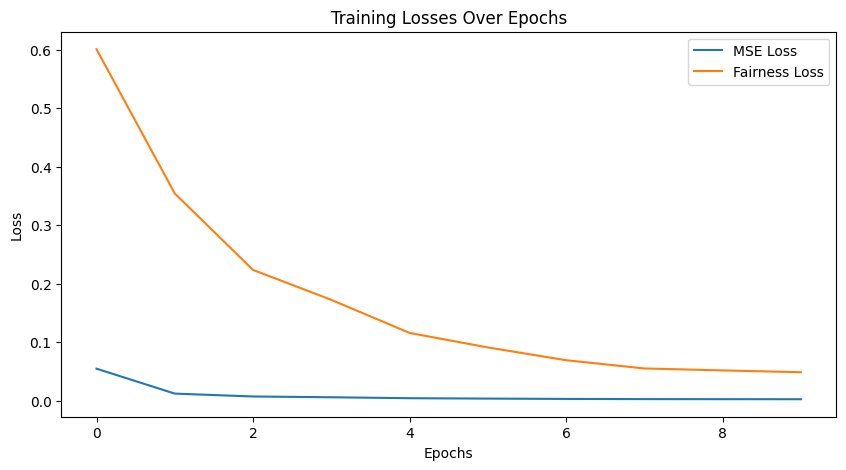

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(mse_losses, label='MSE Loss')
plt.plot(fairness_losses, label='Fairness Loss')
plt.title('Training Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
autoencoder.eval()
dist_gen.eval()
